# VIB Demo 2021

This notebook aims to serve as a modern tutorial introduction to the variational information bottleneck method of [Alemi et al 2016](https://arxiv.org/abs/1612.00410).

## Setup

We'll use pip to upgrade several packages.  Its recommended to select a GPU runtype above.  Use Runtime -> Change runtime type -> GPU before running this notebook.

### Installs

In [1]:
#@title installs
!pip install --upgrade flax optax einops

Next we'll import the packages we'll use here. We're going to use `jax` and `tensorflow_probability` to do the heavy lifting here.

### Imports

In [2]:
import jax
import jax.numpy as np
from jax import grad, vmap, jit, random
import flax
import flax.linen as nn
import matplotlib.pyplot as plt
import einops
import tensorflow_probability.substrates.jax as tfp
tfd = tfp.distributions
from functools import partial
import tensorflow_datasets as tfds
import typing
from typing import Any
import chex
import optax


We'll experiment on the MNIST dataset which we can load in memory.

### Data

In [3]:
# From https://twitter.com/alemi/status/1042834067173957632
"Here is a one line MNIST Dataset Loader in Python in a tweet."
import numpy as onp
import imageio
ims, labels = onp.split(imageio.imread(
    "https://gist.github.com/alexalemi/4b240729f6ce8aa62b24b4eb1cc34167/raw/2b7211ce842a262684b453746de4e0946c29c2cc/mnist.png").ravel(),
    [-70000]); ims, labels = [onp.split(y, [60000]) for y in (ims.reshape((-1, 28, 28)), labels.ravel())]


In [4]:
train_ims, test_ims = ims
train_lbs, test_lbs = labels
cut = 100
x = train_ims[:cut]
y = train_lbs[:cut]
test_batch = (test_ims[:100], test_lbs[:100])

### Utils

Some helpful utility functions and things we'll use below.

In [5]:
from IPython.display import display_png
import matplotlib.cm as cm
import matplotlib as mpl
import six

def imify(arr, vmin=None, vmax=None, cmap=None, origin=None):
  """Convert an array to an image."""
  sm = cm.ScalarMappable(cmap=cmap)
  sm.set_clim(vmin, vmax)
  if origin is None:
    origin = mpl.rcParams["image.origin"]
  if origin == "lower":
    arr = arr[::-1]
  rgba = sm.to_rgba(arr, bytes=True)
  return rgba

def rawarrview(array, **kwargs):
  """Visualize an array as if it was an image in colab notebooks.

  Arguments:
    array: an array which will be turned into an image.
    **kwargs: Additional keyword arguments passed to imify.
  """
  f = six.BytesIO()
  imarray = imify(array, **kwargs)
  plt.imsave(f, imarray, format="png")
  f.seek(0)
  dat = f.read()
  f.close()
  display_png(dat, raw=True)

In [6]:
def reshape_image_batch(ims, cut=None, rows=None):
  if cut is not None:
    ims = ims[:cut]
  n = ims.shape[0]
  if rows is None:
    rows = int(np.sqrt(n))
  cols = n // rows

  return einops.rearrange(
      ims, '(rows cols) x y -> (rows x) (cols y)', rows=rows, cols=cols)

In [7]:
def batcher(rng, batch_size, ims, lbs):
  """Creates a python iterator that batches data."""
  n = ims.shape[0]
  while True:
    rng, spl = random.split(rng)
    pks = random.permutation(spl, n)
    ims = ims[pks]
    lbs = lbs[pks]
    for i in range(n // batch_size):
      yield (ims[i * batch_size: (i+1) * batch_size],
             lbs[i * batch_size: (i+1) * batch_size],)

In [8]:
def generate_tril_dist(params, dim=2):
  """Given flat parameters, assemble a MultivariateTril Distribution."""
  loc = params[..., :dim]
  tril_params = tfp.bijectors.FillScaleTriL(
      diag_bijector=tfp.bijectors.Exp(),
      diag_shift=None).forward(params[..., dim:])
  return tfd.MultivariateNormalTriL(loc=loc, scale_tril=tril_params)

In [9]:
@flax.struct.dataclass
class Store:
  """A simple dataclass to hold our optimization data."""
  params: chex.Array
  state: Any
  rng: Any
  step: int = 0

In [10]:
seethrough = plt.cm.colors.ListedColormap([(0,0,0,0), (0,0,0,1)])
colors = plt.cm.tab10(np.linspace(0,1,10))

def add_im(axs, im, xy, h=0.3, **kwargs):
  x, y = xy
  axs.imshow(im, extent = (x - h/2, x+h/2, y-h/2, y+h/2),
             cmap=seethrough, zorder=2, **kwargs)

In [11]:
def ellipse_coords(cov):
  """Given a Covariance matrix, return the Ellipse coordinates."""
  u, v = jax.scipy.linalg.eigh(cov)
  width = np.sqrt(5.991*u[1])
  height = np.sqrt(5.991*u[0])
  angle = np.arctan2(v[1][1], v[1][0])
  return width, height, angle

In [12]:
from matplotlib.patches import Ellipse 
def add_ellipse(axs, mean, cov, color, alpha=0.4):
  width, height, angle = ellipse_coords(cov)
  ep = Ellipse(xy=(mean[0], mean[1]),
               width=width, height=height,
               angle=np.degrees(angle),
               color=color, alpha=alpha,
               fill=False, linewidth=2)
  axs.add_artist(ep)

## Model

To start we'll create the model components, here the encoder which will take 
our images and turn them into our vector representation.

Next we'll define our classifier, the network that will take the vector representation and predict which class each of the images are in.

In [13]:
class Encoder(nn.Module):
  """The encoder takes in images and spits out a vector representation."""
  output_dim: int = 2
  
  @nn.compact
  def __call__(self, x):
    # We'll use a simple feed forward neural network.
    x = np.expand_dims(x, -1) / 128.0 - 1.0
    x = einops.rearrange(x, 'b x y d -> b (x y d)')
    x = nn.Dense(512)(x)
    x = nn.LayerNorm()(nn.gelu(x))
    y = nn.Dense(512)(x)
    y = nn.LayerNorm()(nn.gelu(y))
    x = x + nn.gelu(y)
    z = nn.Dense(self.output_dim)(x)
    return z


class Classifier(nn.Module):
  """The classifier takes the representation and attempts to predict a label."""

  @nn.compact
  def __call__(self, x):
    #A single hidden layer neural network.
    y = nn.Dense(32)(x)
    y = nn.LayerNorm()(nn.gelu(y))
    return nn.Dense(10)(y)

## Deterministic Classifier

### Model definition

In [14]:
class Deterministic(nn.Module):
  """Represents a traditional, deterministic classifier."""
  z_dim: int = 2  # size of the intermediate representation.

  def setup(self):
    self.encoder = Encoder(self.z_dim)
    self.classifier = Classifier()

  def encode(self, x):
    return self.encoder(x)

  def classify(self, z):
    return self.classifier(z)

  def __call__(self, x):
    z = self.encode(x) 
    return self.classify(z)

### Training

In [15]:
# in JAX we need to be deliberate about our randomness, we'll choose a seed here
rng = random.PRNGKey(0)
# We'll generate our first model, the deterministic network here.
model = Deterministic()
# We'll initialize the model and get its parameters.
logits, params = model.init_with_output(rng, x)
nparams = jax.tree_util.tree_reduce(lambda acc, val: acc + np.prod(np.array(val.shape)), params, 0)
print(f'Number of parameters: {nparams:,}')

Number of parameters: 668,140


We'll write a simple loss function where the first argument is the parameters, thsi will make it easy for us to use JAX's automatic differentiation capabilities to generate the gradients for optimization.

In [16]:
@jit
def loss(params, batch):
  """The loss function for our deterministic network."""
  ims, lbs = batch
  # Compute the logits for each image by going through the model.
  logits = model.apply(params, ims)
  # Use those to create a categorical distribution.
  pred_dist = tfd.Categorical(logits=logits)
  # Evaluate the negative log likelihood
  class_err = -pred_dist.log_prob(lbs).mean()
  # Output several statistics that we can look at.
  aux = {'correct': logits.argmax(axis=-1) == lbs,
         'logits': logits,
         'class_err': class_err,
         'preddist': pred_dist}
  # JAX expects the first argument to be a scalar
  #  that we can differentiate.
  return class_err, aux

To optimize we'll use the [adabelief](https://arxiv.org/abs/2010.07468) as implemented in [optax](https://github.com/deepmind/optax).  Optax separates gradient computation from the application of updates, the basic usage looks something like this:

    opt = optax.sgd(learning_rate)
    state = opt.init(params)

    def train_step(state, args):
      grads = jax.grad(loss)(params, *args)
      updates, state = opt.update(grads, state, params)
      params = optax.apply_updates(params, updates)
      return state


In [17]:
opt = optax.adabelief(1e-4)
store = Store(params, opt.init(params), rng, 0)
batches = batcher(rng, 500, train_ims, train_lbs)
testset = (test_ims, test_lbs)

In [18]:
@jit
def train_step(store: Store, batch):
  """Implements a training set, computing and applying gradients for a batch."""
  (val, aux), grads = jax.value_and_grad(loss, has_aux=True)(store.params, batch)
  updates, state = opt.update(grads, store.state, store.params)
  params = optax.apply_updates(store.params, updates)
  return store.replace(
      params=params,
      state=state,
      step=store.step+1), (val, aux)

Now we can train for a while and observe as the network makes better predictions.

In [19]:
for step, batch in zip(range(6_000), batches):
  store, (val, aux) = train_step(store, batch)
  if store.step % 300 == 0:
    print(f"step = {store.step}, train acc = {aux['correct'].mean():0.2%} train loss = {val:.3}", flush=True)
    # Evaluate on the test set
    tval, taux = loss(store.params, testset)
    print(f"test acc = {taux['correct'].mean():0.2%}  test loss = {taux['class_err'].mean():.3}", flush=True)

step = 300, train acc = 75.60% train loss = 1.11
test acc = 79.04%  test loss = 1.1
step = 600, train acc = 88.40% train loss = 0.693
test acc = 87.39%  test loss = 0.676
step = 900, train acc = 93.40% train loss = 0.453
test acc = 89.26%  test loss = 0.533
step = 1200, train acc = 92.00% train loss = 0.428
test acc = 91.23%  test loss = 0.445
step = 1500, train acc = 96.00% train loss = 0.287
test acc = 91.87%  test loss = 0.398
step = 1800, train acc = 94.00% train loss = 0.309
test acc = 92.19%  test loss = 0.359
step = 2100, train acc = 96.60% train loss = 0.198
test acc = 92.85%  test loss = 0.33
step = 2400, train acc = 96.40% train loss = 0.187
test acc = 93.33%  test loss = 0.309
step = 2700, train acc = 98.80% train loss = 0.102
test acc = 93.34%  test loss = 0.313
step = 3000, train acc = 99.00% train loss = 0.104
test acc = 93.74%  test loss = 0.295
step = 3300, train acc = 97.20% train loss = 0.152
test acc = 93.65%  test loss = 0.294
step = 3600, train acc = 99.00% train l

After training, our final parameters are stored in `store.params` which we could use to evaluate the full training set accuracy

In [20]:
val, aux = loss(store.params, (train_ims, train_lbs))
print(f"Final Train accuracy: {aux['correct'].mean():0.2%}")

Final Train accuracy: 99.74%


We can also visualize our representation, since we chose a two dimensional representation its easy to render a simple scatterplot.

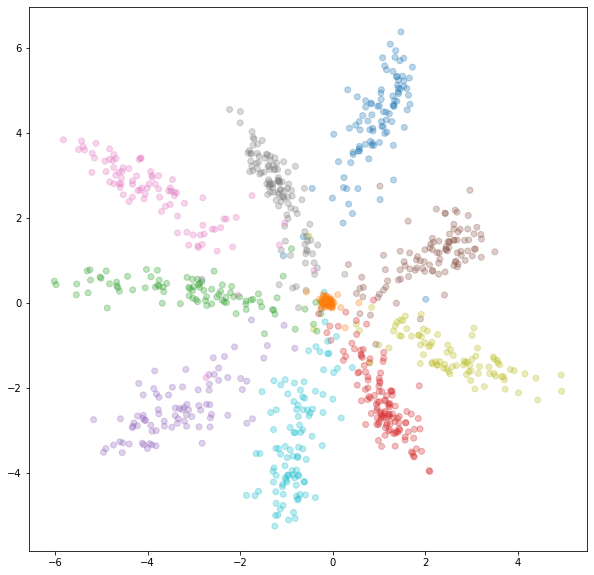

In [21]:
fig, axs = plt.subplots(figsize=(10, 10))
xx = test_ims[::10]
yy = test_lbs[::10]
zs = model.apply(store.params, xx, method=model.encode)
axs.scatter(zs[...,0], zs[...,1], c=yy, cmap='tab10', alpha=0.3);

Notice that the network has learned to separate the different classes (here each point is colored according to which class it is.) 

To better see what is going on we can embed some example images onto the scene.

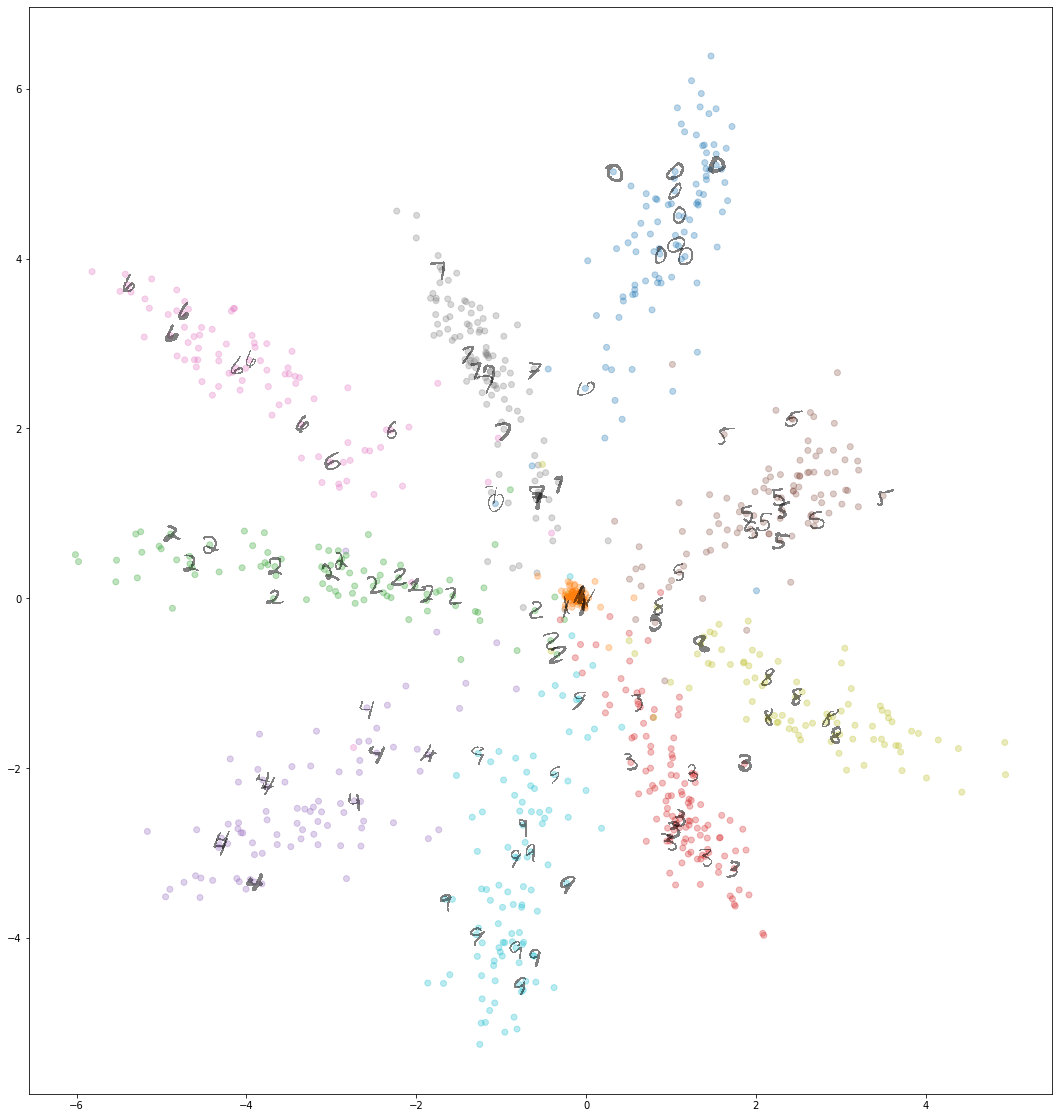

In [22]:
fig, axs = plt.subplots(figsize=(20,20))
axs.scatter(zs[...,0], zs[...,1], c=yy, cmap='tab10', alpha=0.3);
xlim = plt.xlim()
ylim = plt.ylim()

for i in range(1, xx.shape[0],10):
  add_im(axs, xx[i], zs[i], h=0.3, alpha=0.5)

plt.xlim(xlim)
plt.ylim(ylim);

# VIB

Now we'll try to train a VIB version of this network.  Whereas before we learned a determinsitic representation of each image, now our representation will be stochastic, each image will be mapped to a distribution. 

We'll keep things two dimensional, so we'll use a two dimensional Normal distribution, parameterized by a two dimensional mean and three parameters we'll use to parameterize the covariance matrix.

In [23]:
class VIB(nn.Module):
  """An implementation of the Variational Information Bottleneck Method."""
  z_dim: int = 2
  mix_components: int = 32

  def setup(self):
    # We'll use the same encoder as before but predict additional parameters
    #  for our distribution.
    num_params = self.z_dim + (self.z_dim * (self.z_dim + 1))//2
    self.encoder = Encoder(output_dim=num_params, name='encoder')
    # We'll use the same classifier as before
    self.decoder = Classifier(name='classifier')
    # We also need a marginal distribution, here we'll use a fixed
    #  isotropic Gaussian, though this could also be learned.
    self.marginal = tfd.MultivariateNormalDiag(loc=np.zeros(self.z_dim))

  def encode(self, x):
    """Take an image and return a two dimensional distribution."""
    params = self.encoder(x)
    return generate_tril_dist(params, self.z_dim)

  def decode(self, z_samps):
    """Given a sampled representation, predict the class."""
    logits = self.decoder(z_samps)
    return tfd.Categorical(logits=logits)

  def __call__(self, rng, batch, num_samps=16):
    """Compute relevant VIB quantities."""
    ims, lbs = batch
    z_dist = self.encode(ims)
    z_samps = z_dist.sample((num_samps,) if num_samps > 1 else (), seed=rng)
    y_dist = self.decode(z_samps)

    lps = y_dist.log_prob(lbs)
    class_err = -lps.mean(0)
    rate = (z_dist.log_prob(z_samps) - self.marginal.log_prob(z_samps)).mean(0)

    logits = y_dist.logits
    correct = y_dist.logits.argmax(-1) == lbs 

    # Now that we have a stochastic representation, we can marginalize out
    #  that representation to get increased predictive performance.
    lse_class_err = -jax.nn.logsumexp(lps - np.log(num_samps), axis=0)
    lse_correct = jax.nn.logsumexp(
        y_dist.logits - np.log(num_samps), axis=0).argmax(-1) == lbs

    return {'class_err': class_err, 'rate': rate, 'correct': correct,
            'lse_correct': lse_correct, 'lse_class_err':lse_class_err,
            'logits': logits }

Create the model and initialize the parameters.

In [24]:
vib = VIB()
aux, vib_params = vib.init_with_output(rng, rng, batch)
vib_store = Store(vib_params, opt.init(vib_params), rng)

Our new loss is:

$$ \left\langle -\log q(y|z) + \beta \log \frac{p(z|x)}{q(z)} \right\rangle $$

or 

$$ C + \beta R $$

the combinatino of our classification error (the term on the left), and
$\beta$ times the *rate* $R$.

In [25]:
@jit
def vib_loss(params, rng, batch, beta=0.5):
  aux = vib.apply(params, rng, batch)
  loss = aux['class_err'].mean() + beta * aux['rate'].mean()
  return loss, aux

The VIB train step is same as before, though now we also update the random seed each step as our representation is stochastic.

In [26]:
@jit
def vib_train_step(store: Store, batch):
  rng, spl = random.split(store.rng)
  (val, aux), grads = jax.value_and_grad(vib_loss, has_aux=True)(store.params, spl, batch)
  updates, state = opt.update(grads, store.state, store.params)
  params = optax.apply_updates(store.params, updates)
  return store.replace(
      params=params,
      state=state,
      step=store.step+1,
      rng=rng), (val, aux)

In [27]:
for step, batch in zip(range(3_000), batches):
  vib_store, (val, aux) = vib_train_step(vib_store, batch)
  if vib_store.step % 300 == 0:
    print(f"step = {store.step}, train acc = {aux['correct'].mean():0.2%} lse acc = {aux['lse_correct'].mean():0.2%}  train loss = {val:.3}", flush=True)
    # Evaluate on the test set
    tval, taux = vib_loss(vib_store.params, rng, testset, 128)
    print(f"test acc = {taux['correct'].mean():0.2%}  rate: {taux['rate'].mean():.3}  lse_acc = {taux['lse_correct'].mean():0.2%}", flush=True)

step = 6000, train acc = 20.74% lse acc = 30.20%  train loss = 2.37
test acc = 20.89%  rate: 0.34  lse_acc = 29.24%
step = 6000, train acc = 20.98% lse acc = 27.60%  train loss = 2.31
test acc = 24.41%  rate: 0.411  lse_acc = 30.29%
step = 6000, train acc = 29.15% lse acc = 35.00%  train loss = 2.25
test acc = 29.43%  rate: 0.611  lse_acc = 35.91%
step = 6000, train acc = 34.33% lse acc = 44.40%  train loss = 2.19
test acc = 36.28%  rate: 0.901  lse_acc = 47.41%
step = 6000, train acc = 40.13% lse acc = 55.40%  train loss = 2.11
test acc = 41.51%  rate: 1.1  lse_acc = 57.24%
step = 6000, train acc = 45.94% lse acc = 62.60%  train loss = 2.06
test acc = 48.05%  rate: 1.34  lse_acc = 64.95%
step = 6000, train acc = 52.85% lse acc = 72.60%  train loss = 2.0
test acc = 52.97%  rate: 1.48  lse_acc = 71.23%
step = 6000, train acc = 55.84% lse acc = 79.20%  train loss = 1.97
test acc = 56.22%  rate: 1.58  lse_acc = 78.33%
step = 6000, train acc = 60.99% lse acc = 85.00%  train loss = 1.91
tes

Now each image, instead of returning a point actually returns an entire distribution.

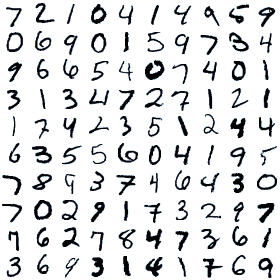

In [28]:
rawarrview(reshape_image_batch(test_batch[0]), cmap='bone_r')

In [29]:
z_dist = vib.apply(vib_store.params, test_batch[0], method=vib.encode)
print(z_dist)

tfp.distributions.MultivariateNormalTriL("MultivariateNormalTriL", batch_shape=[100], event_shape=[2], dtype=float32)


We can visualize the probability distribution associated with any one image.

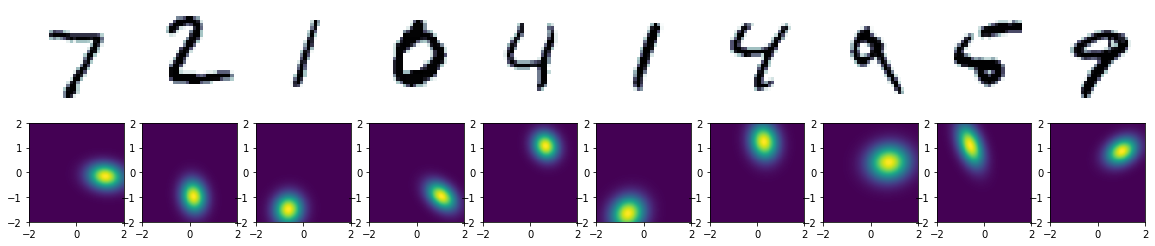

In [30]:
xs = np.linspace(-2, 2, 300)
zs = np.array(np.meshgrid(xs, xs)).T
probs = z_dist.prob(zs[..., None, :])

fig, axs = plt.subplots(2, 10, figsize=(20, 4))
for i in range(10):
  axs[0,i].imshow(test_batch[0][i], cmap='bone_r')
  axs[0,i].axis('off');
  axs[1,i].pcolor(xs, xs, probs[..., i])


For example, it we look at the two 1s in the batch above, looking at samples from the encoder its difficult to tell them apart, the VIB encoder has learned to map the two images to very similar *distributions*.

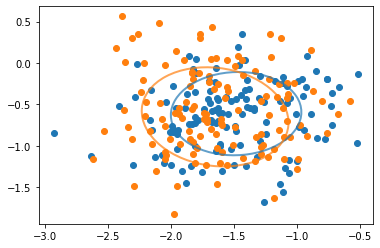

In [31]:
z_samps = z_dist.sample((128,), seed=rng)
fig, axs = plt.subplots()
axs.scatter(*z_samps[:, 2].T);
axs.scatter(*z_samps[:, 5].T);
add_ellipse(axs, z_dist.mean()[2], z_dist.covariance()[2], 'C0', alpha=0.7)
add_ellipse(axs, z_dist.mean()[5], z_dist.covariance()[5], 'C1', alpha=0.7)

We can visualize the mean of the embeddings of each image.

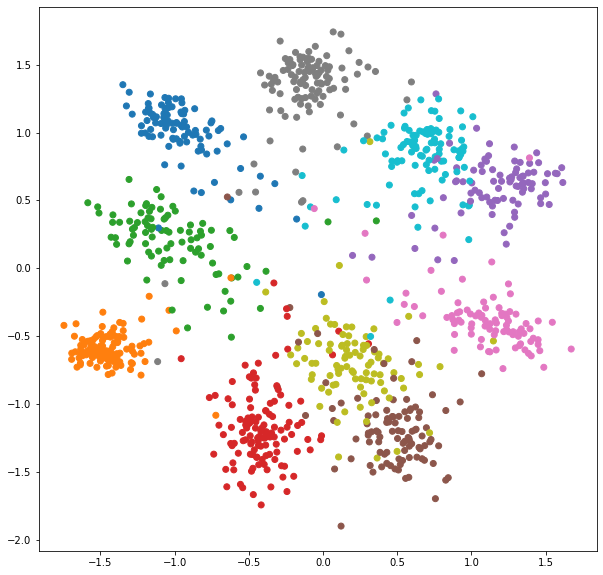

In [32]:
fig, axs = plt.subplots(figsize=(10, 10))
z_dist = vib.apply(vib_store.params, xx, method=vib.encode)
means = z_dist.mean()
covs = z_dist.covariance()
axs.scatter(means[..., 0], means[..., 1], c=yy, cmap='tab10');

To better visualize what is happening, we can show each distribution with an ellipse denoting its one sigma contour.

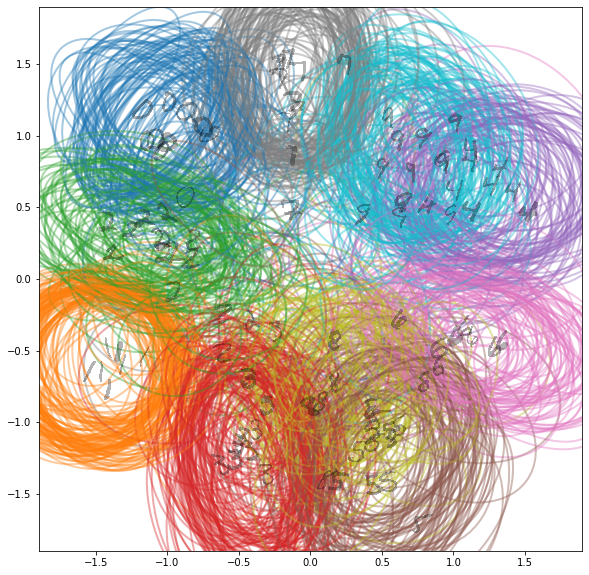

In [33]:
from matplotlib.patches import Ellipse
fig, axs = plt.subplots(figsize=(10,10));

for i in range(1000):
  add_ellipse(axs, means[i], covs[i], colors[yy[i]])
  
# axs.grid('off');
# axs.patch.set_facecolor('white')
edge = np.max(np.abs(means))
axs.set_xlim((-edge,edge))
axs.set_ylim((-edge,edge));

for i in range(1,xx.shape[0],10):
  add_im(axs, xx[i], means[i], h=0.2, alpha=0.3)

Notice that the ellipses are frequently on top of one another, the network has thrown out a lot of the information contained in the original image and now largely focusses on its class.

In [34]:
aux = vib.apply(vib_store.params, rng, (xx, yy))

In [35]:
(~aux['lse_correct']).sum()

DeviceArray(147, dtype=int32)

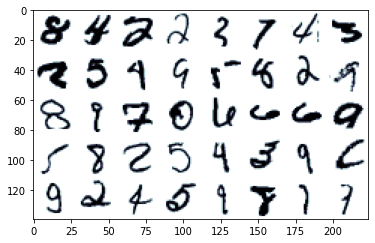

In [36]:
args = aux['lse_class_err'].argsort()
plt.imshow(einops.rearrange(np.take(xx, args[-40:], axis=0), '(h1 h2) x y -> (h1 x) (h2 y)', h1=5, h2=8), cmap='bone_r')

In [37]:
xs = np.linspace(-2, 2, 300)
all_zs = np.array(np.meshgrid(xs, xs)).T
y_dist = vib.apply(vib_store.params, all_zs, method=vib.decode)